# Diamond EP Grouping by Resolution Limit - Feature Selection


Try to identify which features help model, and try to leave out uninformative features

In [19]:
import sys
import os
dirpath = r'C:\Users\César\PycharmProjects\Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, pd, np, plt, plot_original_data
plt.style.use("ggplot")

Want to see which features are more important. Already have correlations table, but now fit optimised random forest and see which features are most important. The computations were done on a 1000 iteration RandomisedSearch on the DLS computer cluster.

DIALS


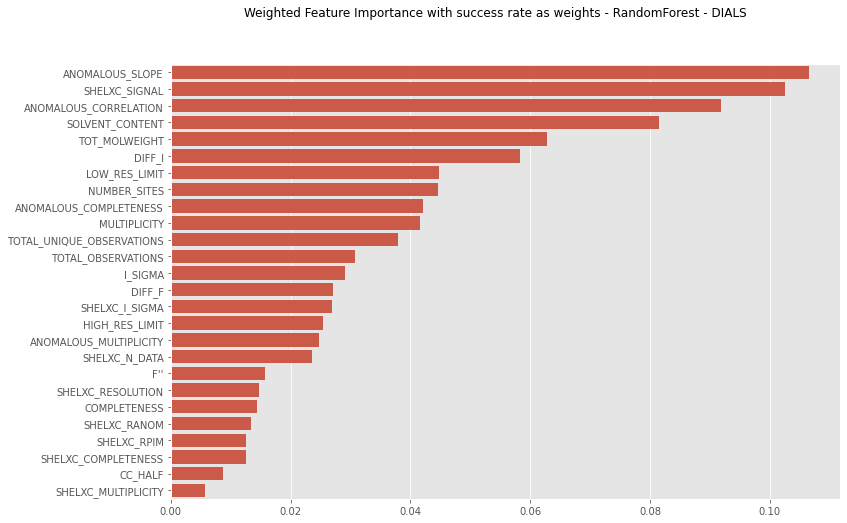

------------------------------------------------------------
3DII


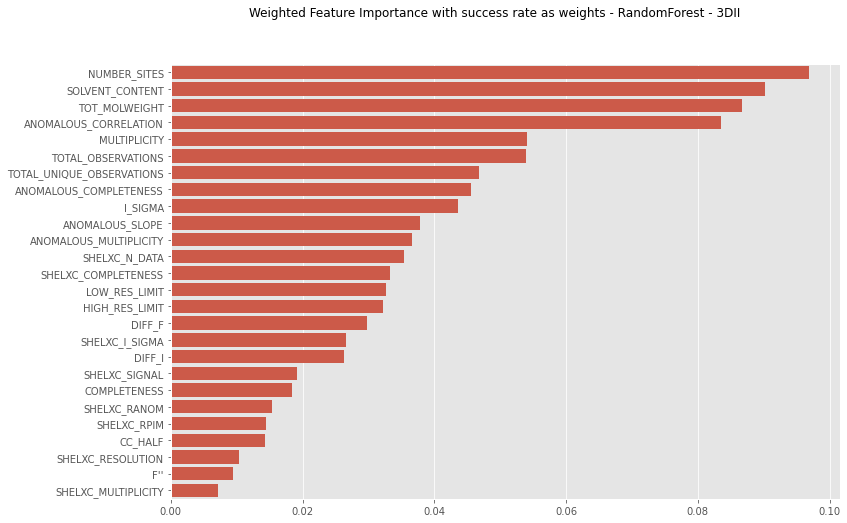

------------------------------------------------------------


In [73]:
import seaborn as sns


for db_kind in ["dials", "3dii"]:
    print(db_kind.upper())
    topfeats, weights,  = [], []
    
    # loop through every dataset
    for i in np.arange(1, 101):
        db_dir = fr"D:\Diamond\analysis\results\dataset_{i}\{db_kind}"
        
        # try to get feature importance csv data
        try:
            topfeat = pd.read_csv(os.path.join(db_dir, "topfeat.csv"), squeeze=True, index_col=0)
            cols = topfeat.index
            topfeats.append(topfeat.values.tolist())
            
            # get target for success rate to be used as weight
            y = data[db_kind].y
            success_rate = y.sum() / y.size
            weights.append(success_rate)
            
        # default to 0 if not found
        except FileNotFoundError:
            topfeats.append([0 for i in range(len(cols))])
            weights.append(0)

    
    # organise and sort top features
    topfeats = np.array(topfeats)
    topfeats_avg = np.average(topfeats, weights=weights, axis=0)
    topfeats_avg = pd.Series(topfeats_avg, index=cols).sort_values(ascending=False)
    
    # create figure
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Weighted Feature Importance with success rate as weights - RandomForest - {db_kind.upper()}")
    sns.barplot(x=topfeats_avg.values, y=topfeats_avg.index, color="C0")
    plt.show()
    
    print("-"*60)

Previously saw that SHELXC RPIM/RANOM are highly intercorrelated - see if they can be summarised into a single feature.

DIALS
Normal
> F1 Score: 68.04% +- 2.95%
> MCC: 54.61% +- 3.96%
PCA
> F1 Score: 66.52% +- 2.85%
> MCC: 53.05% +- 4.19%
Remove
> F1 Score: 68.97% +- 3.13%
> MCC: 56.08% +- 4.23%


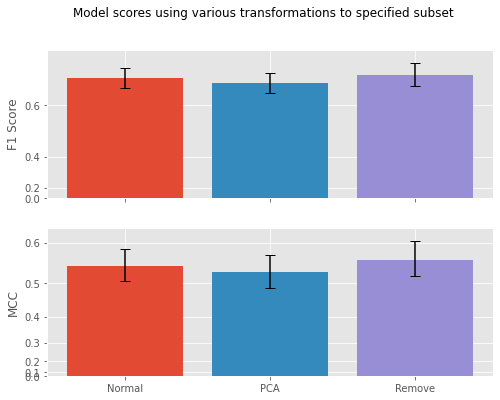

3DII
Normal
> F1 Score: 71.87% +- 0.58%
> MCC: 41.54% +- 1.04%
PCA
> F1 Score: 71.69% +- 0.34%
> MCC: 41.03% +- 1.05%
Remove
> F1 Score: 71.83% +- 0.25%
> MCC: 40.87% +- 0.58%


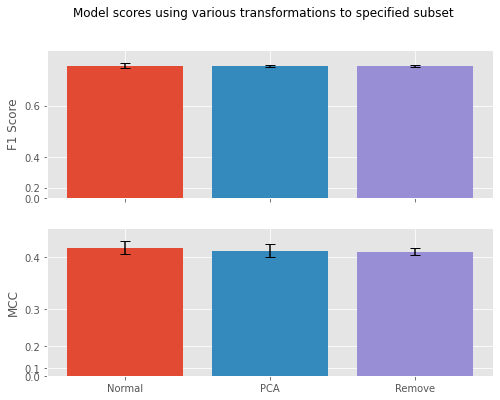

In [10]:
import seaborn as sns
from pca import pca as PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform, sem
mcc = make_scorer(matthews_corrcoef)


def test_normal_pca_remove(estimator, X, y, feat2test, show=True, show_pca=False, random_state=None):
    # do PCA on two features
    pca = PCA(normalize=True, n_components=0.95)
    new = pca.fit_transform(X.loc[:, feat2test], verbose=2)
    if show_pca:
        pca.plot()

    # get new data subsets
    X_remove = X.drop(feat2test, axis=1)
    X_pca = X_remove.copy()
    X_pca = pd.concat([X_pca, new["PC"]], axis=1)
    
    # prepare figure
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    
    for i, (x_part, name) in enumerate(zip([X, X_pca, X_remove], ["Normal", "PCA", "Remove"])):
        print(name)
        
        f1s = cross_val_score(forest, x_part, y, scoring='f1', cv=5, n_jobs=-1)
        mccs = cross_val_score(forest, x_part, y, scoring=mcc, cv=5, n_jobs=-1)
        f1_val, f1_err = f1s.mean(), sem(f1s)
        mcc_val, mcc_err = mccs.mean(), sem(mccs)
        
        ax1.bar(i, f1_val, yerr=f1_err, capsize=5)
        ax2.bar(i, mcc_val, yerr=mcc_err, capsize=5)
        
        print(f"> F1 Score: {f1_val:.2%} +- {f1_err:.2%}\n"
              f"> MCC: {mcc_val:.2%} +- {mcc_err:.2%}")
    
    # labels
    ax1.set_ylabel("F1 Score")
    ax2.set_ylabel("MCC")
    ax2.set_xticks([0, 1, 2])
    ax2.set_xticklabels(["Normal", "PCA", "Remove"])
    fig.suptitle(f"Model scores using various transformations to specified subset")
    
    if show:
        plt.show()
    return fig, (ax1, ax2)
    

seed = 1
n_iter = 5

for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["F''"]
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    #sns.lmplot(data=union_part, x="SHELXC_RPIM", y="SHELXC_RANOM", hue="IS_SUCCESS")
    #plt.show()
    
    # create model
    n_iter = 1
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(forest_search, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

Scores equivalent for all - no performance change.

DIALS


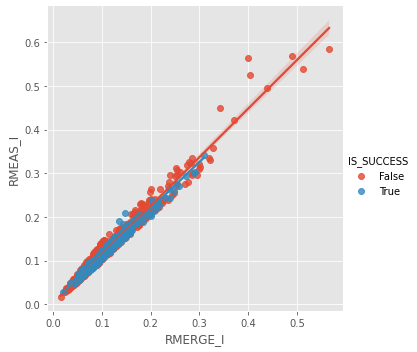

Normal
> F1 Score: 68.04% +- 2.95%
> MCC: 54.61% +- 3.96%
PCA
> F1 Score: 66.65% +- 3.28%
> MCC: 53.01% +- 4.39%
Remove
> F1 Score: 69.38% +- 3.02%
> MCC: 56.18% +- 4.36%


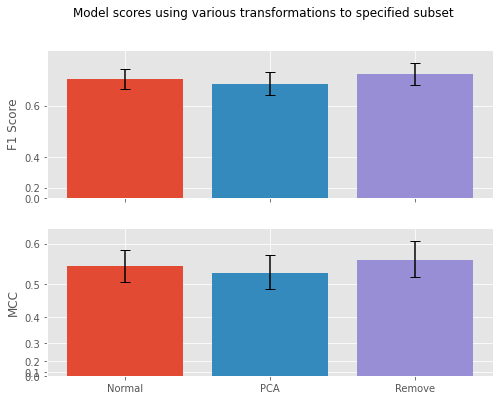

3DII


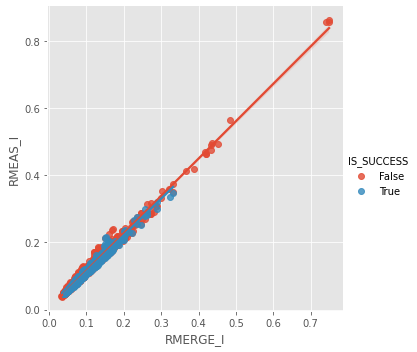

Normal
> F1 Score: 71.87% +- 0.58%
> MCC: 41.54% +- 1.04%
PCA
> F1 Score: 71.43% +- 0.67%
> MCC: 40.66% +- 0.58%
Remove
> F1 Score: 70.70% +- 1.28%
> MCC: 39.89% +- 2.25%


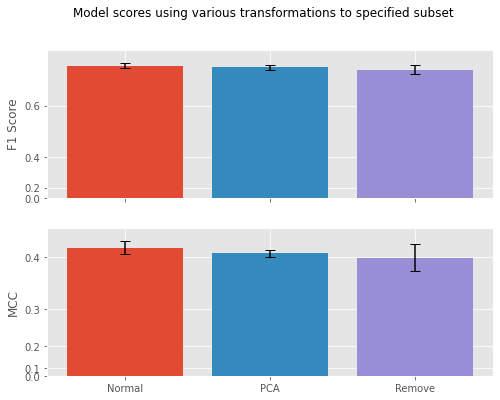

In [42]:
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    seed = 1
    sns.lmplot(data=union_part, x="RMERGE_I", y="RMEAS_I", hue="IS_SUCCESS")
    plt.show()
    
    # create model
    n_iter = 1
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(forest_search, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

Again, little to no change

DIALS


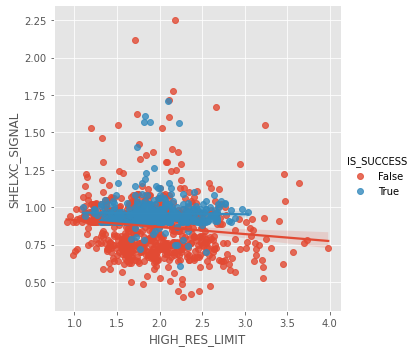

Normal
> F1 Score: 68.04% +- 2.95%
> MCC: 54.61% +- 3.96%
PCA
> F1 Score: 65.91% +- 3.21%
> MCC: 52.84% +- 4.16%
Remove
> F1 Score: 62.37% +- 3.98%
> MCC: 50.00% +- 4.49%


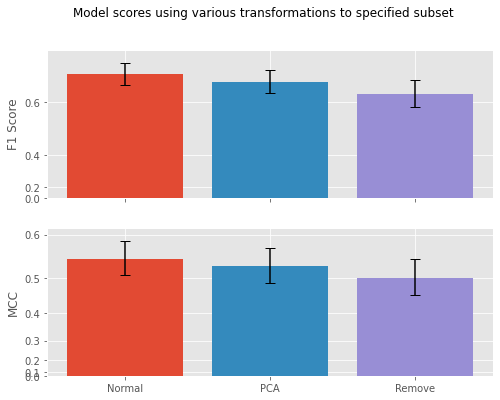

3DII


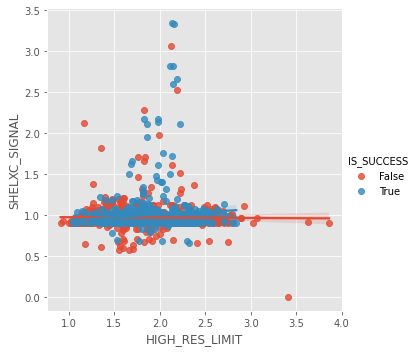

Normal
> F1 Score: 71.87% +- 0.58%
> MCC: 41.54% +- 1.04%
PCA
> F1 Score: 71.17% +- 0.59%
> MCC: 40.23% +- 1.42%
Remove
> F1 Score: 70.04% +- 0.53%
> MCC: 37.39% +- 0.98%


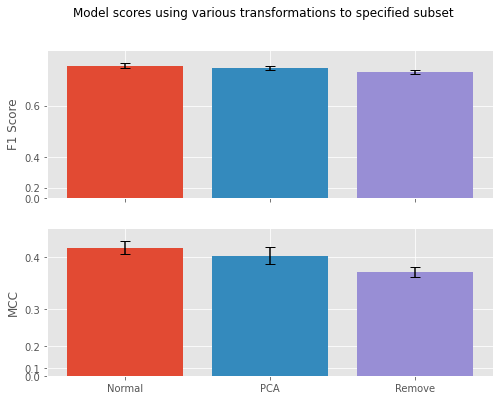

In [43]:
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["HIGH_RES_LIMIT", "SHELXC_SIGNAL", "ANOMALOUS_CORRELATION", "ANOMALOUS_SLOPE"]
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    seed = 1
    sns.lmplot(data=union_part, x=feats2test[0], y=feats2test[1], hue="IS_SUCCESS")
    plt.show()
    
    # create model
    n_iter = 1
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(forest_search, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

DIALS
(1201, 34) (1201,)


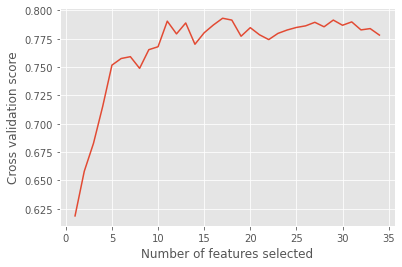

------------------------------------------------------------
3DII
(1450, 34) (1450,)


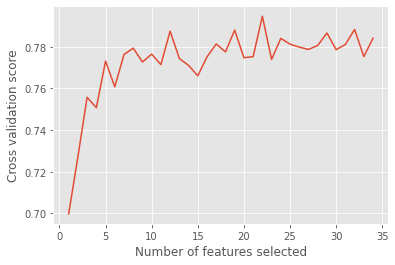

------------------------------------------------------------


In [32]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV, train_test_split



for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    print(x.shape, y.shape)
    
    # create estimators
    seed = 1
    n_iter = 5
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced"))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed, error_score=0)
        
    # separate into train/test datasets and train model
    X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=seed)
    
    # select best features
    selector = RFECV(forest_search, cv=5, scoring="f1", importance_getter="best_estimator_.named_steps.clf.feature_importances_")
    selector.fit(X_train, y_train)
    
    # plot results
    plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score")
    plt.show()
    
    ranking = pd.Series(selector.ranking_, index=x.columns)
    print(ranking)
    print(f"Optimal number of features: {selector.support_}")
    
    print("-"*60)